#### Notebook projet 8 parcours Datascientist Openclassrooms

# Déployez un modèle dans le cloud

## Problématique
- La très jeune start-up de l'AgriTech, nommée **"Fruits!"**, cherche à proposer des solutions innovantes pour la récolte des fruits.

- La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.

- La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

- Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

- De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

![Agritech](https://image.shutterstock.com/image-photo/precision-agriculture-agritech-concept-sensor-260nw-524072110.jpg)

## Objectifs dans ce projet
-Développer une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.
<br />
<br />
-Tenir compte du fait que le volume de données va augmenter très rapidement après la livraison de ce projet, ce qui implique de:
- Déployer le traitement des données dans un environnement **Big Data**
- Développer les scripts en **pyspark** pour effectuer du calcul distribué

![Représentation Spark](https://meritis.fr/wp-content/uploads/2018/11/image3.png)

## Import des librairies

In [1]:
# J'utilise findspark pour le chemin de pyspark et donc rajouter pyspark au sys.path
import findspark
findspark.init()

In [33]:
import matplotlib.pyplot as plt
import cv2

In [2]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# for connections to S3 AWS
import boto3
# pyspark modules
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA
# tnesorflow modules
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

## Workflow

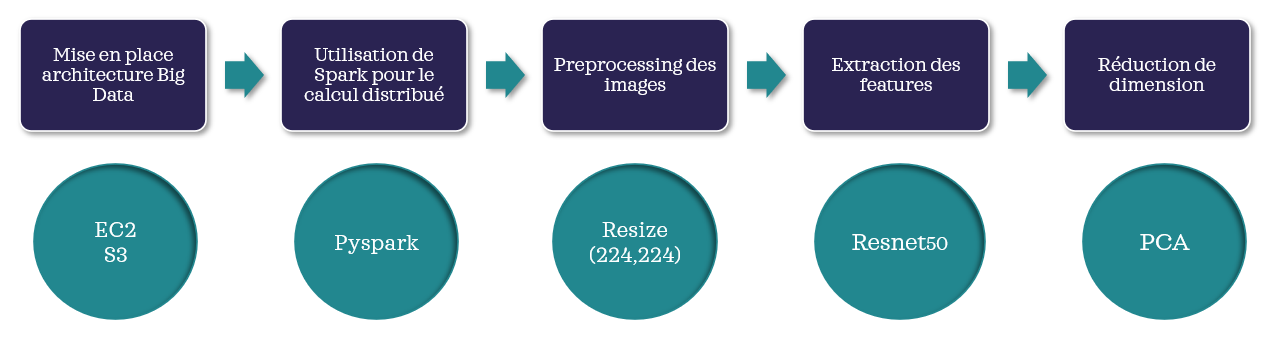

In [40]:
from IPython.display import Image
Image(filename='Capture.PNG')

## Création de la SparkSession
L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé SparkSession.
Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur
dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark.


- Setup des variables d'environnement pour pyspark pour assurer le bon fonctionnement de spark, java, S3, etc.

In [3]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell --conf spark.driver.extraJavaOptions="-Dio.netty.tryReflectionSetAccessible=true",spark.hadoop.fs.s3a.endpoint=s3.eu-west-1.amazonaws.com'

- Spark Session/Context  (Créer le point d'entrée pour Spark) voir https://sparkbyexamples.com/spark/spark-sparkcontext/

- Affichage des informations de Spark en cours d'execution :

In [4]:
sc = SparkContext()
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
# configuration de Pyspark
#s_cf = SparkConf()
#s_cf.set("spark.executor.memory", '4g') # 4GB de RAM pour l'exécuteur
#s_cf.set('spark.executor.cores', '2') # 2 coeurs
#s_cf.set('spark.cores.max', '2') # 2 coeurs max
#s_cf.set("spark.driver.memory",'4g') # 4GB de RAM pour le driver

## Choix de la solution de stockage des données : Amazon S3
Amazon propose une solution très efficace pour la gestion du stockage des données : Amazon S3.
S3 pour Amazon Simple Storage Service.

Il pourrait être tentant de stocker nos données sur l'espace alloué par le serveur EC2, mais si nous ne prenons aucune mesure pour les sauvegarder ensuite sur un autre support, les données seront perdues lorsque le serveur sera résilié (on résilie le serveur lorsqu'on ne s'en sert pas pour des raisons de coût).
De fait, si l'on décide d'utiliser l'espace disque du serveur EC2 il faudra imaginer une solution pour sauvegarder les données avant la résiliation du serveur. De plus, nous serions exposés à certaines problématiques si nos données venaient à saturer l'espace disponible de nos serveurs (ralentissements, disfonctionnements).

Utiliser **Amazon S3** permet de s'affranchir de toutes ces problématiques.
L'espace disque disponible est illimité, et il est indépendant de nos serveurs **EC2**.
L'accès aux données est très rapide car nous restons dans l'environnement d'AWS et nous prenons soin de choisir la même région pour nos serveurs **EC2** et **S3**.

De plus, comme nous le verrons il est possible d'accéder aux données sur **S3** de la même manière que l'on **accède aux données sur un disque local**. Nous utiliserons simplement un PATH au format s3://... .

## Chargement des données
Les images sont chargées au format binaire, ce qui offre, plus de souplesse dans la façon de prétraiter les images.

Importer des données du bucket ```S3``` (j'ai déposé mes images sur le service de stockage S3 de mon compte AWS)

Avant de charger les images, nous spécifions que nous voulons charger uniquement les fichiers dont l'extension est jpg.

Nous indiquons également de charger tous les objets possibles contenus dans les sous-dossiers du dossier communiqué.


Utiliser Spark pour lire les images (https://sparkbyexamples.com/spark/spark-read-binary-file-into-dataframe/)

In [6]:
s3_url = "s3a://projet8-housna2/sampleimages/*"

image_df = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(s3_url)
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



Utiliser withColumn pour rajouter une colonne (https://sparkbyexamples.com/spark/spark-dataframe-withcolumn/)

Affichage des 20 premières images contenant :

- le path de l'image
- son contenu encodé en valeur hexadécimal
- et j'ajoute une colonne contenant les **label** de chaque image :

In [7]:
image_df = image_df.withColumn('label', split(col('path'), '/').getItem(4))
image_df = image_df.select('path', 'content', 'label')
image_df.show()

+--------------------+--------------------+---------+
|                path|             content|    label|
+--------------------+--------------------+---------+
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|   lychee|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|   lychee|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|   lychee|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|   lychee|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|   lychee|
|s3a://projet8-hou...|[FF D8 FF E0 00 1...|Raspberry|
|s3a://projet8-hou...|[FF D8

## definition des fonctions

- Definition d'une série de fonctions qui sera éxecutée sur tous les noeuds, venant de ce website: <br>
https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

In [8]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

- Preprocessing

In [9]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

- Model predictions giving features as output

In [10]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

- Wrapping up tout ensemble en utilisant pandas udf pour appliquer les fonctions sur ```spark df``` pour udf (https://databricks.com/fr/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html)

In [11]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## Import du model ResNet50 pré-entrainé 

- On importe le modéle ResNet50 de ```keras``` mais sans la dernière couche (classifier), car je souhaite  l'utiliser  juste pour extraire les features

![Représentation Resnet50](https://www.researchgate.net/profile/Bendjillali-Ridha-Ilyas-2/publication/338253578/figure/fig3/AS:842071023824896@1577776785660/The-proposed-Resnet50-CNN-architecture.ppm)

In [12]:
model = ResNet50(include_top=False)

- Broadcasting model weights to all nodes  (https://sparkbyexamples.com/spark/spark-broadcast-variables/)

In [13]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

## Featurizing data

J'utilise  **pandas udf** pour appliquer les fonctions sur toutes les données et je crée une nouvelle colonne ```features```

In [14]:
features_df = image_df.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+---------+--------------------+
|                path|    label|            features|
+--------------------+---------+--------------------+
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|   lychee|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|   lychee|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|   lychee|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://projet8-hou...|   

- Postprocessing des features via ```Vectors.dense``` et ```pandas udf```

In [15]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [16]:
#pip install opencv-python

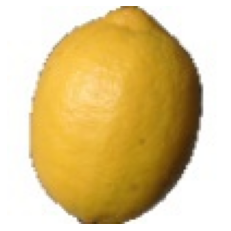

In [17]:
import matplotlib.pyplot as plt
import cv2
# Image originale
img = cv2.imread("0_100.jpg")# this is read in BGR format
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# this converts it into RGB
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

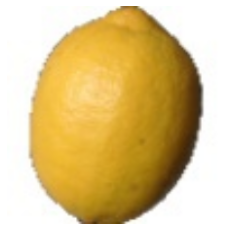

In [18]:
# Resizing
resizing = cv2.resize(rgb_img, (224, 224))
plt.imshow(resizing)
plt.axis('off')
plt.show()

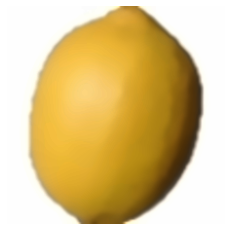

In [19]:
# Réduction de bruits
f_denoising = cv2.fastNlMeansDenoisingColored(resizing,None,10,10,7,21)
plt.imshow(f_denoising)
plt.axis('off')
plt.show()

## Réduction de dimension avec PCA "Principal Components Analysis"

### Preprocessing
- L'input du PCA **doit** etre standardisé (scaled)

In [20]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='feats_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [21]:
features_df_scaled.printSchema()
features_df_scaled.show(6) 

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)

+--------------------+---------+--------------------+--------------------+
|                path|    label|            features|        feats_scaled|
+--------------------+---------+--------------------+--------------------+
|s3a://projet8-hou...|Raspberry|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://projet8-hou...|Raspberry|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://projet8-hou...|Raspberry|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://projet8-hou...|Raspberry|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://projet8-hou...|Raspberry|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://projet8-hou...|   lychee|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
+--------------------+---------+--------------------+--------------------+
only showing top 6 rows



### PCA fit transform

In [22]:
pca = PCA(k=7, inputCol="feats_scaled", outputCol="pca")
modelpca = pca.fit(features_df_scaled)
transformed = modelpca.transform(features_df_scaled)

In [23]:
transformed.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)
 |-- pca: vector (nullable = true)



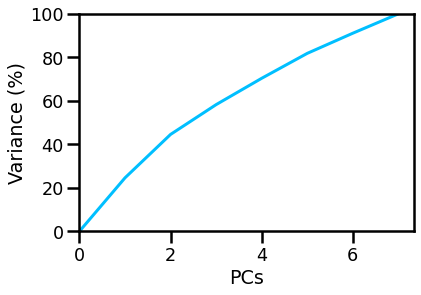

In [24]:
var = modelpca.explainedVariance.cumsum()
sns.set_context(context='poster', font_scale=0.8)
sns.lineplot(x=[i for i in range(8)], y=np.insert(var,0,0)*100, color='deepskyblue')
plt.xlabel('PCs')
plt.ylabel('Variance (%)')
plt.ylim(0,100)
plt.xlim(left=0)
plt.show()

In [25]:
transformed_final = transformed.select('path', 'label', 'pca')
transformed_pandas = transformed_final.toPandas()

In [26]:
transformed_pandas

,path,label,pca
0,s3a://projet8-housna2/sampleimages/Raspberry/1...,Raspberry,"[-56.733978042628436, -66.12241836240305, 17.7..."
1,s3a://projet8-housna2/sampleimages/Raspberry/2...,Raspberry,"[-77.19369523465224, -101.43787711960597, 27.9..."
2,s3a://projet8-housna2/sampleimages/Raspberry/3...,Raspberry,"[-71.60831322099533, -103.06617138626997, 27.8..."
3,s3a://projet8-housna2/sampleimages/Raspberry/4...,Raspberry,"[-70.1849502782406, -83.70509265352807, 29.879..."
4,s3a://projet8-housna2/sampleimages/Raspberry/2...,Raspberry,"[-70.31388924128497, -113.68073572152248, 22.9..."
5,s3a://projet8-housna2/sampleimages/lychee/168_...,lychee,"[-59.603522004738615, 116.0438951827288, -13.3..."
6,s3a://projet8-housna2/sampleimages/lychee/174_...,lychee,"[-53.652993554958535, 97.97742775110875, -12.0..."
7,s3a://projet8-housna2/sampleimages/Raspberry/r...,Raspberry,"[-34.525875224335664, -55.649808992276725, -13..."
8,s3a://projet8-housna2/sampleimages/lychee/131_...,lychee,"[-52.66940536829465, 91.15633112935168, -14.66..."
9,s3a://projet8-housna2/sampleimages/Raspberry/r...,Raspberry,"[-54.33748974020993, -89.25817812601683, -18.0..."


In [31]:
#transformed_final.write.parquet('s3a://projet8-housna2/PCA_output.parquet')

In [27]:
# Transformation en dataframe pandas avec séparation des features dans une colonne dédiée

dfspark = spark.read.parquet("s3a://projet8-housna2/PCA_output.parquet")
df_p = dfspark.toPandas()
df_p.sample(3)

,path,label,pca
1,s3a://projet8-housna2/sampleimages/Raspberry/2...,Raspberry,"[-77.19369523465231, -101.43787711960603, 27.9..."
0,s3a://projet8-housna2/sampleimages/Raspberry/1...,Raspberry,"[-56.73397804262847, -66.12241836240308, 17.71..."
17,s3a://projet8-housna2/sampleimages/lychee/288_...,lychee,"[-48.692983320391924, 77.8304722335896, -10.91..."


In [28]:
# Mise en place d'un Dataframe avec pour chaque fruit une séparation en colonne de chaque feature identifié

df_final = pd.DataFrame(np.zeros((df_p.shape[0], 5)))
for i in range(5):
    df_final.loc[:,i] = df_p["pca"].apply(lambda x : x[i])

df_final_pca = pd.concat([df_p['label'], df_final], axis=1)

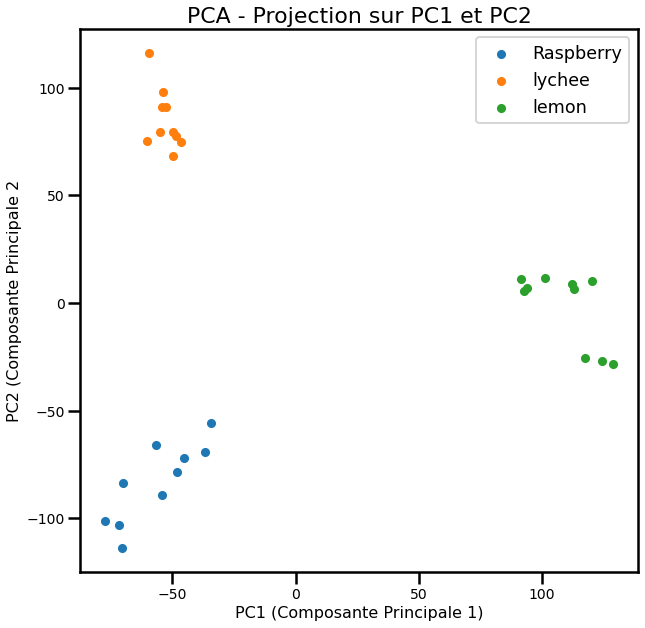

In [29]:
# Visualisation des différents fruits par projection sur les 2 axes principaux d'inertie

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PC1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PC2 (Composante Principale 2',fontsize=16)

for fruit in df_final_pca.label.unique():
    dfred = df_final_pca[df_final_pca.label==fruit]
    plt.scatter(dfred[0], dfred[1], label=fruit, s=50)

plt.title("PCA - Projection sur PC1 et PC2",fontsize=22)

plt.legend()    
plt.show()

In [30]:
#pip install s3fs

In [32]:
#transformed_pandas.to_csv('s3://p8bucket-hartmann/PCA_output/PCA_output.csv', index=False)